In [1]:
import os, sys
import re
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from glob import glob
from konlpy.tag import Mecab
from gensim.models.ldamodel import LdaModel
from datetime import datetime
from scipy.special import rel_entr
from typing import Dict,List
import random
import warnings
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from topic_transformer import *
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

sys.path.append('../')
warnings.filterwarnings('ignore')
mecab = Mecab('C:\mecab\mecab-ko-dic')

C:\Users\jisoo\anaconda3\envs\virtualenv_python36\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


# Load Models

In [2]:
def normalize_text(text):
    doublespace_pattern = re.compile('\s+')
    text = str(text)
    text = doublespace_pattern.sub(' ', text)
    return text.strip()

In [3]:
ldamodel_path = r'D:\notebooks\kisdi\lda_100\ldamodel'
ldamodel = LdaModel.load(ldamodel_path)
# train_data = [normalize_text(doc) for doc in doc_list]

In [4]:
model_path = {'TopicTransformer_TEHead': 'TT_TEHead_epoch20.pt',
              'TopicTransformer_MLP': 'TT_MLP_epoch40.pt',
              'TopicTransformer_LSTM': 'TT_LSTM_epoch20.pt',
              'TopicTransformer_nonFreeze': r'D:\notebooks\kisdi\models\tt_5_100topics.pt',
              'TopicTransformer_freeze': r'D:\notebooks\kisdi\models\tt_5_100topics_freeze.pt'}

In [5]:
model_name = 'TopicTransformer_freeze'
if model_name=='TopicTransformer_MLP':
    model = TopicTransformer_MLP(output_dim = 100,
                                 transformer_model_name='xlm-roberta-base',
                                 num_head_layers=3,
                                 head_hidden_dims=[1024,512,256])

elif model_name=='TopicTransformer_LSTM':
    model = TopicTransformer_LSTM(output_dim = 100,
                              transformer_model_name='xlm-roberta-base',
                              lstm_num_layers=2,
                              lstm_hidden_size=512)

elif model_name=='TopicTransformer_TEHead':
    model = TopicTransformer_TEHead(output_dim = 100,
                             transformer_model_name='xlm-roberta-base')

elif model_name=='TopicTransformer_nonFreeze':
    model = TopicTransformer(output_dim=100,
                             transformer_model_name='xlm-roberta-base')

elif model_name=='TopicTransformer_freeze':
    model = TopicTransformer(output_dim=100,
                             transformer_model_name='xlm-roberta-base')

else:
    raise ValueError('model name not in model_path keys')
model.load_state_dict(torch.load(model_path[model_name]))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

# Evaluate

In [6]:
class TestDataset(Dataset):
    def __init__(self, test_docs, num_topics=100):
        self.test_docs = test_docs
        self.num_topics = num_topics

    def __len__(self):
        return len(self.test_docs)

    def __getitem__(self, idx):
        doc = self.test_docs[idx]

        return doc, _

def symm_kl(p,q):
    return 0.5*(sum(rel_entr(p,q)) + sum(rel_entr(q,p)))

def cos_sim(p,q):
    return (1 - cosine(p,q))

In [7]:
def get_pred_dic(data_path: str) -> Dict[str, List[List[float]]]:

    # load data
    data = pd.read_csv(data_path)
    test_list_en = []
    test_list_ko = []
    if data_path.split('\\')[-1].startswith("scopus"):
        for i,a in data.iterrows():
            test_list_en.append(normalize_text(a['abstract']))
            test_list_ko.append(normalize_text(a['translated']))
    else:
        for i,a in data.iterrows():
            test_list_en.append(normalize_text(a['요약문_번역']))
            test_list_ko.append(normalize_text(a['요약문_연구내용']))
    pred_dic = {}
    ko_corpus = [[word for word in mecab.nouns(i) if len(word)>1] for i in test_list_ko]

    # pred lda
    pred_dic['lda'] = []
    for i in ko_corpus:
        corpus = ldamodel.id2word.doc2bow(i)
        pred_dic['lda'].append([prob for (idx,prob) in ldamodel.get_document_topics(corpus, minimum_probability=1e-5)])

    # pred en
    test_batch_size = 16
    test_dataset = TestDataset(test_list_en, num_topics=100)
    test_dataloader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=False)
    pred_dic['en'] = []
    model.eval()
    model.to(device)
    for batch in test_dataloader:
        with torch.no_grad():
            features, _ = batch
            pred = model(list(features), device=device)
            pred_dic['en'].extend([i.cpu().tolist() for i in pred])

    # pred ko
    test_dataset = TestDataset(test_list_ko, num_topics=100)
    test_dataloader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=False)
    pred_dic['ko'] = []
    model.eval()
    model.to(device)
    for batch in test_dataloader:
        with torch.no_grad():
            features, _ = batch
            pred = model(list(features), device=device)
            pred_dic['ko'].extend([i.cpu().tolist() for i in pred])

    return pred_dic

In [8]:
def get_score(p: str, q: str, pred_dic: Dict[str, List[List[float]]], metric:str = "symm-kl") -> None:

    random.seed(42)
    pred_types = {'en': 'ko_transformer(en)',
                  'ko': 'ko_transformer(ko)',
                  'lda': 'ko_lda',
                  'random_ko': 'random shuffle(ko)',
                  'random_en': 'random shuffle(en)',
                  'random_lda': 'random shuffle(lda)'}
    if p not in pred_types:
        raise KeyError("p not in pred types: ['en','ko','lda]")
    if q not in pred_types:
        raise KeyError("q not in pred types: ['en','ko','lda','random']")

    src = pred_dic[p]
    if q.startswith('random'):
        if q=='random_ko':
            tgt = sorted(pred_dic['ko'], key=lambda x: random.random())
        elif q=='random_en':
            tgt = sorted(pred_dic['en'], key=lambda x: random.random())
        else:
            tgt = sorted(pred_dic['lda'], key=lambda x: random.random())
    else:
        tgt = pred_dic[q]

    score = 0
    if metric=="symm-kl":
        for i in range(10000):
            score += symm_kl(src[i], tgt[i])
    else:
        for i in range(10000):
            score += cos_sim(src[i], tgt[i])
    score /= 10000
    print(f'{pred_types[p]} - {pred_types[q]} distance : {score}')

## SCOPUS Evaluate

In [9]:
pred_dic_scopus = get_pred_dic(r'D:\data\translated\scopus_translated.csv')
get_score('en','ko',pred_dic_scopus)
get_score('en','lda',pred_dic_scopus)
get_score('ko','lda',pred_dic_scopus)
get_score('en','random_lda',pred_dic_scopus)
get_score('ko','random_lda',pred_dic_scopus)

ko_transformer(en) - ko_transformer(ko) distance : 0.0032101338399954343
ko_transformer(en) - ko_lda distance : 2.951755391608523
ko_transformer(ko) - ko_lda distance : 2.966283440369344
ko_transformer(en) - random shuffle(lda) distance : 2.9539416130308025
ko_transformer(ko) - random shuffle(lda) distance : 2.969114641970076


In [10]:
get_score('en','ko',pred_dic_scopus,metric="cos-sim")
get_score('en','lda',pred_dic_scopus,metric="cos-sim")
get_score('ko','lda',pred_dic_scopus,metric="cos-sim")
get_score('en','random_lda',pred_dic_scopus,metric="cos-sim")
get_score('ko','random_lda',pred_dic_scopus,metric="cos-sim")

ko_transformer(en) - ko_transformer(ko) distance : 0.9963310728257162
ko_transformer(en) - ko_lda distance : 0.23760335927198453
ko_transformer(ko) - ko_lda distance : 0.238691903223161
ko_transformer(en) - random shuffle(lda) distance : 0.23665789902048978
ko_transformer(ko) - random shuffle(lda) distance : 0.2375614447242476


## NTIS evaluate

In [11]:
pred_dic_ntis = get_pred_dic(r'D:\data\translated\ntis_translated.csv')
get_score('en','ko',pred_dic_ntis)
get_score('en','lda',pred_dic_ntis)
get_score('ko','lda',pred_dic_ntis)
get_score('en','random_lda',pred_dic_ntis)
get_score('ko','random_lda',pred_dic_ntis)

ko_transformer(en) - ko_transformer(ko) distance : 0.005877322302505595
ko_transformer(en) - ko_lda distance : 3.376610176014001
ko_transformer(ko) - ko_lda distance : 3.4141503818161882
ko_transformer(en) - random shuffle(lda) distance : 3.3817952222894636
ko_transformer(ko) - random shuffle(lda) distance : 3.420659043882705


In [12]:
get_score('en','ko',pred_dic_ntis,metric="cos-sim")
get_score('en','lda',pred_dic_ntis,metric="cos-sim")
get_score('ko','lda',pred_dic_ntis,metric="cos-sim")
get_score('en','random_lda',pred_dic_ntis,metric="cos-sim")
get_score('ko','random_lda',pred_dic_ntis,metric="cos-sim")

ko_transformer(en) - ko_transformer(ko) distance : 0.9936522141376034
ko_transformer(en) - ko_lda distance : 0.19621566621709385
ko_transformer(ko) - ko_lda distance : 0.19378206365404776
ko_transformer(en) - random shuffle(lda) distance : 0.19513912998369168
ko_transformer(ko) - random shuffle(lda) distance : 0.19194131715870238


# Show Topic Distribution

In [13]:
def show_topic_dists(doc_num: int,
                     model_name: str,
                     data: str) -> None:

    if data=='scopus':
        pred_dic = pred_dic_scopus.copy()
    elif data=='ntis':
        pred_dic = pred_dic_ntis.copy()
    else:
        raise ValueError('data out of range!!!')

    plt.figure(figsize=(20,12))
    bar_width=0.25
    plt.bar(np.arange(100),
            pred_dic['en'][doc_num],
            bar_width,
            color='blue',
            label='Ko_transformer(en)')
    plt.bar(np.arange(100)+bar_width,
            pred_dic['ko'][doc_num],
            bar_width,
            color='orange',
            label='Ko_transformer(ko)')
    plt.bar(np.arange(100)+2*bar_width,
            pred_dic['lda'][doc_num],
            bar_width,
            color='gray',
            label='Ko_LDA')
    plt.legend()
    plt.title(f"{model_name} : {data} Inference_example1")
    plt.show()

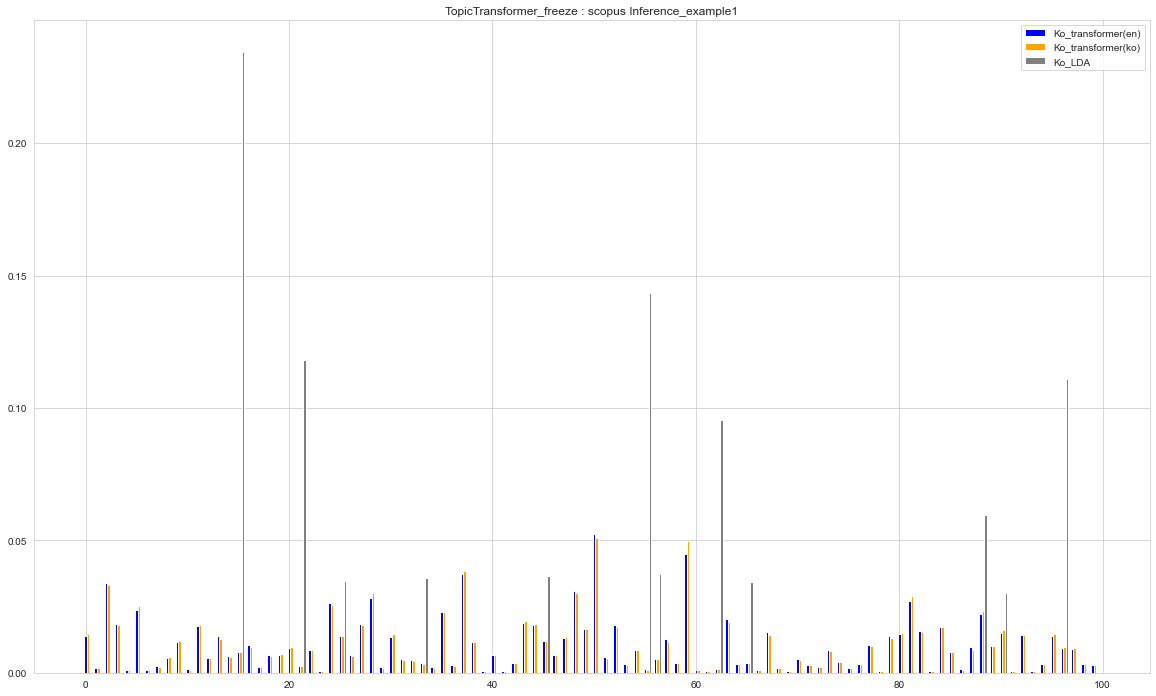

In [14]:
show_topic_dists(11, model_name, "scopus")

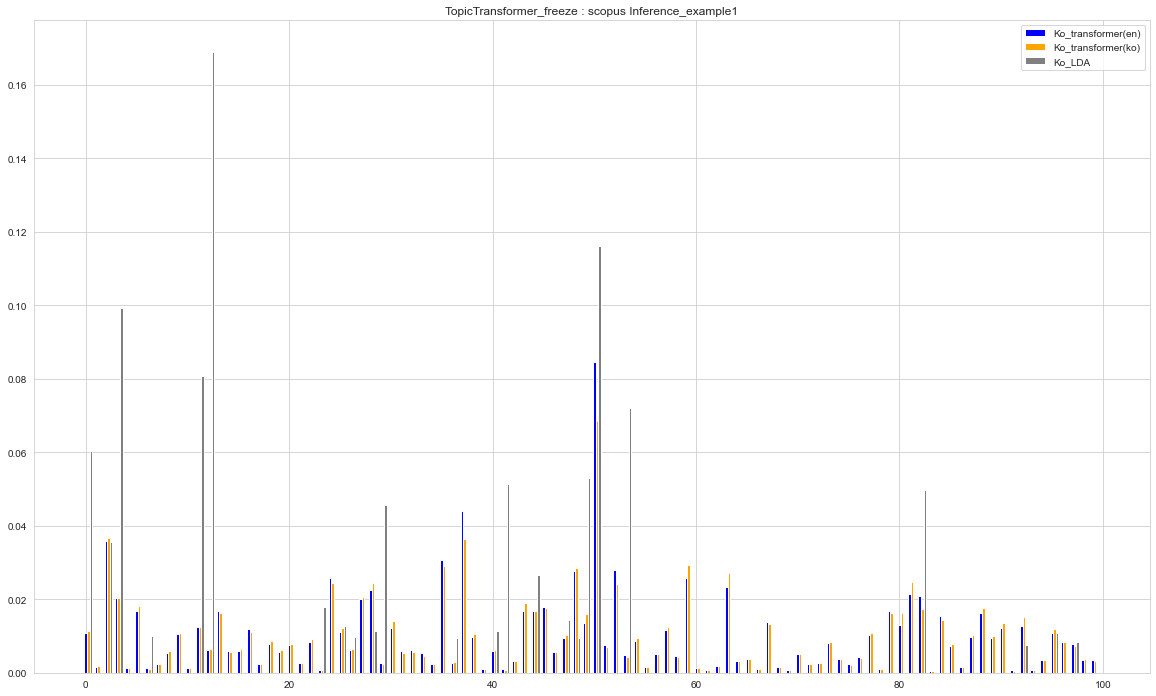

In [15]:
show_topic_dists(2, model_name, "scopus")

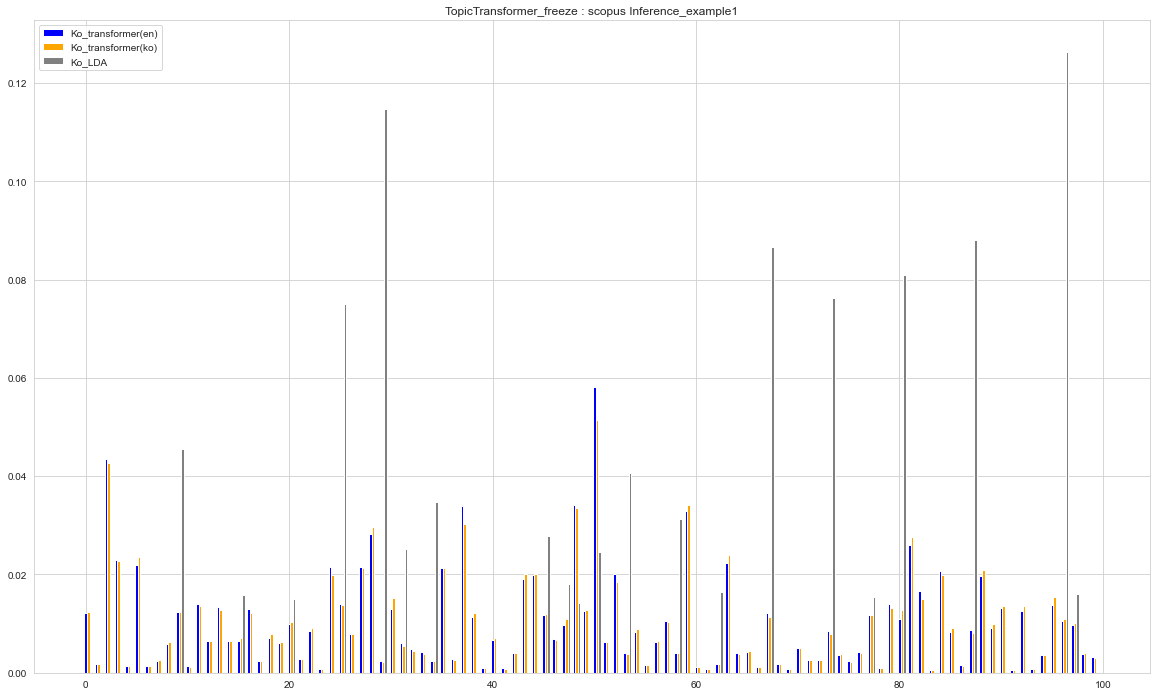

In [16]:
show_topic_dists(777, model_name, "scopus")

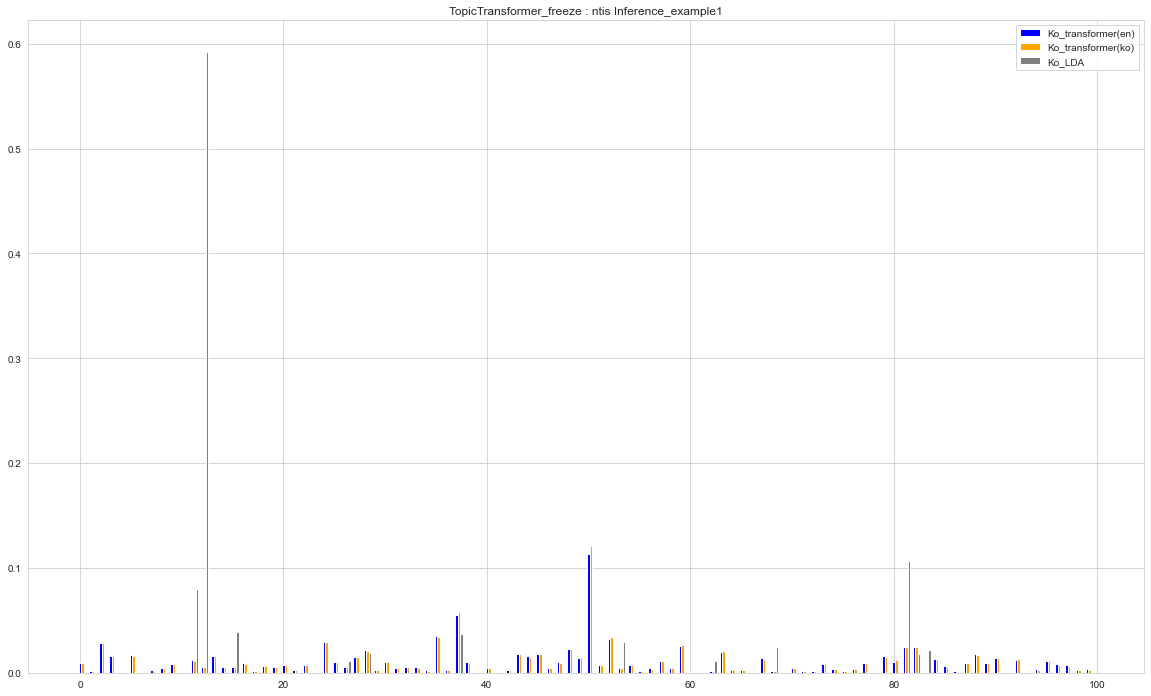

In [17]:
show_topic_dists(11, model_name, "ntis")

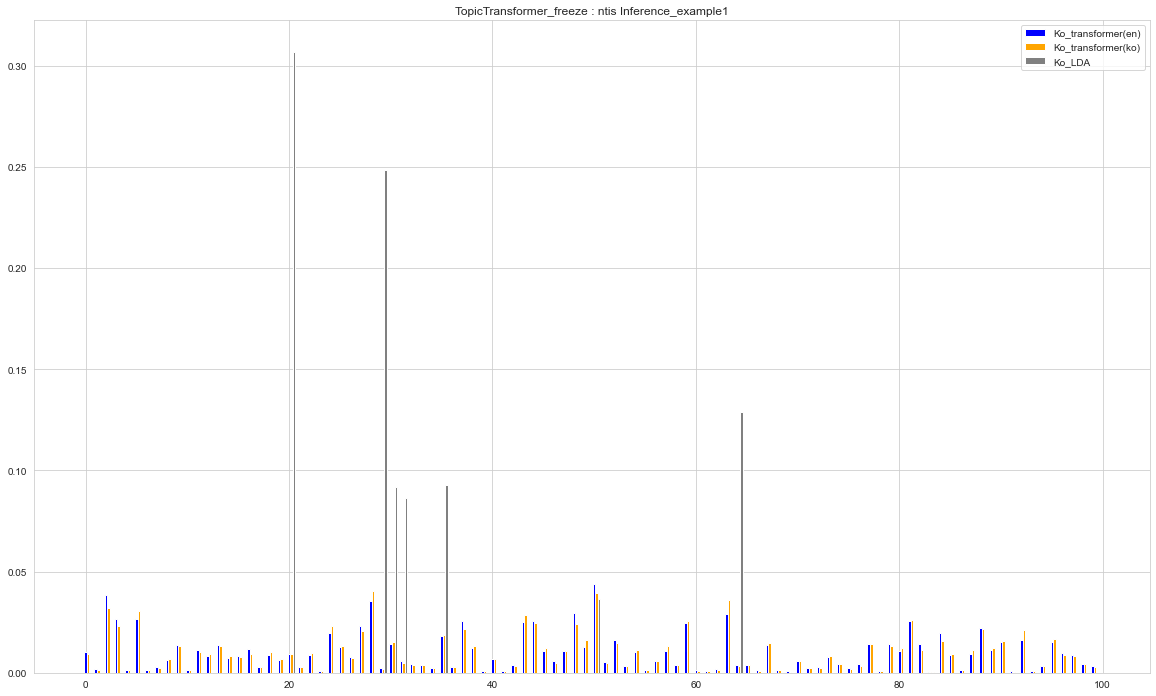

In [18]:
show_topic_dists(2, model_name, "ntis")

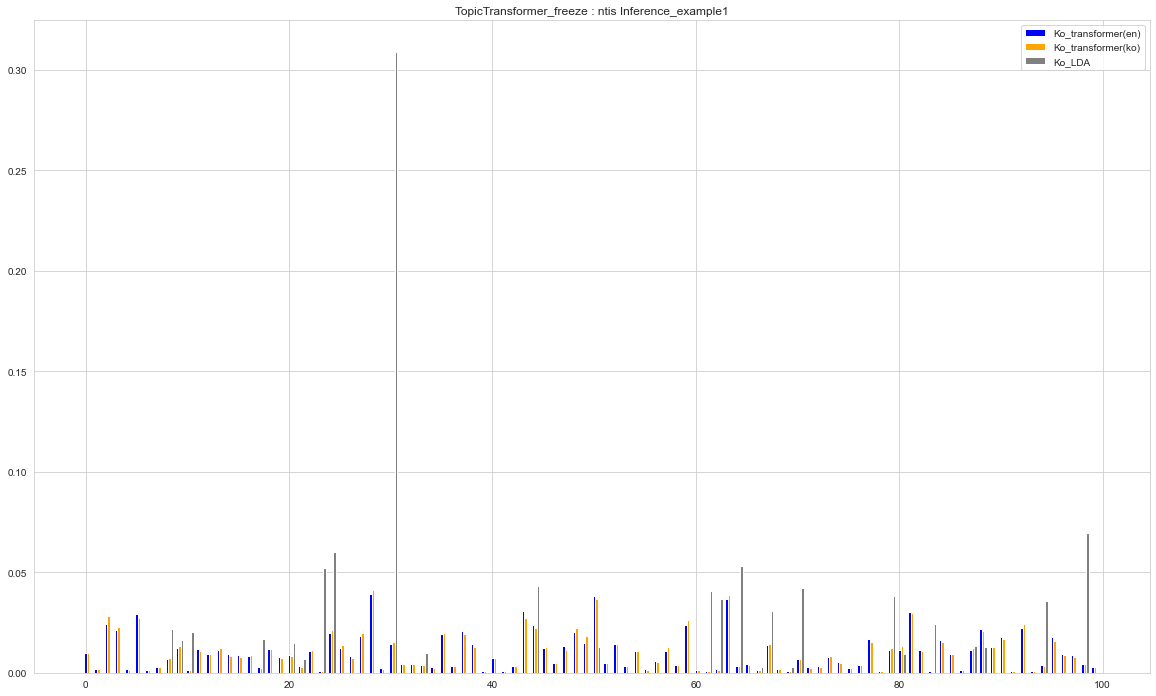

In [19]:
show_topic_dists(777, model_name, "ntis")